In [1]:
%%capture
# install SAM + dependencies
! pip install git+https://github.com/facebookresearch/segment-anything.git
! pip install torch torchvision matplotlib opencv-python scikit-image

In [2]:
import numpy as np
import cv2
import tifffile
import matplotlib.pyplot as plt
from skimage.exposure import equalize_adapthist
from segment_anything import SamPredictor, SamAutomaticMaskGenerator, sam_model_registry
from sam import MODEL_ROOT, DATA_ROOT

# Helper functions

In [5]:
def convert_eight_bit_2d(img, kernel_size=np.array([100, 100])):
    """
    Performs CLAHE filtering, range normalizes, and sets range to 0 - 255
    """
    norm_img = equalize_adapthist(img, kernel_size=kernel_size)
    bg_subtract = norm_img - norm_img.min()

    if bg_subtract.max() == 0:
        return np.zeros(img.shape, dtype="uint8")
    else:
        range_norm = bg_subtract / bg_subtract.max()
        return np.array(range_norm * 255, dtype="uint8")
    
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [11]:
sam = sam_model_registry["vit_h"](checkpoint=MODEL_ROOT)
#device = "cuda"
#sam.to(device=device)
predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam)
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100, 
)

(1184, 1778, 3)


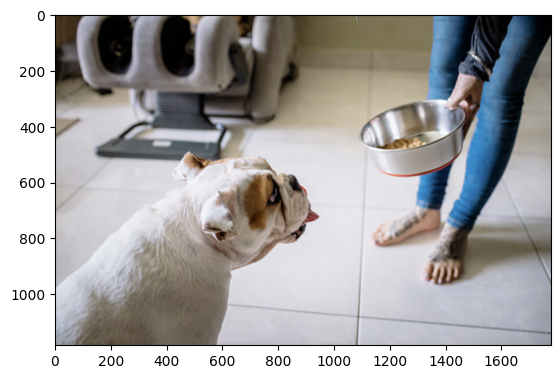

In [10]:
image = cv2.imread("./data/dog.png").astype(np.uint8)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)
plt.imshow(image)


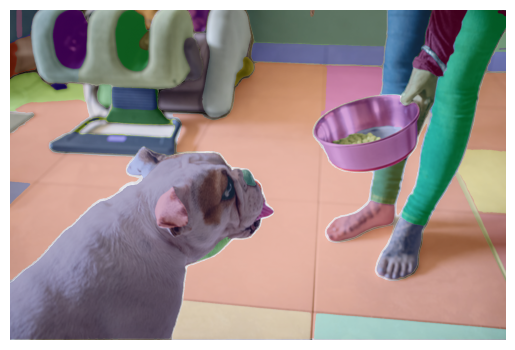

In [12]:
masks = mask_generator.generate(image)
plt.figure()
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

# Example with cells

In [13]:
sample_image = tifffile.imread(DATA_ROOT)
sample_image = convert_eight_bit_2d(sample_image)
sample_image = np.expand_dims(sample_image, axis=-1)
sample_image = cv2.merge((sample_image[:, :, 0], 
                          np.zeros(shape=(sample_image.shape[0], sample_image.shape[1]), dtype="uint8"),
                          np.zeros(shape=(sample_image.shape[0], sample_image.shape[1]), dtype="uint8")))
sample_image.shape

(3960, 3953, 3)

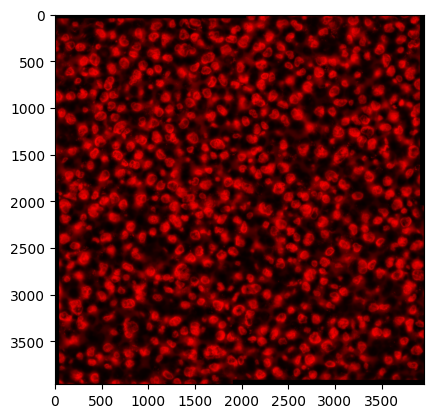

In [14]:
plt.imshow(sample_image)

In [17]:
masks = mask_generator.generate(sample_image)

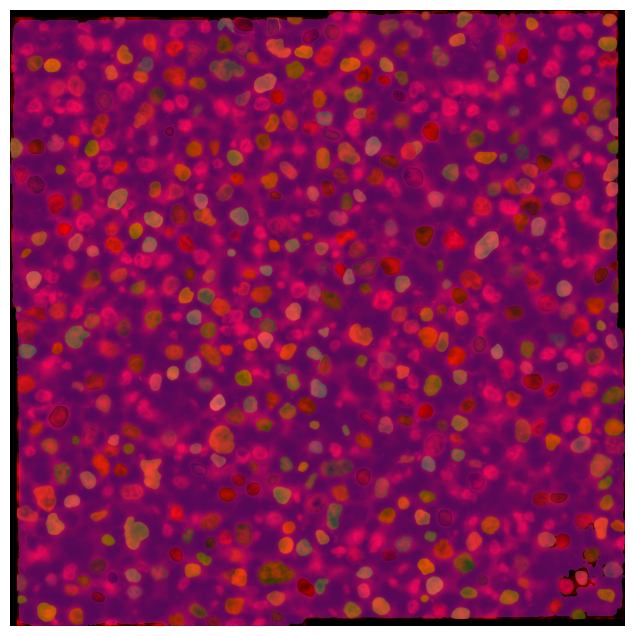

In [18]:
plt.figure(figsize=(8,8))
plt.imshow(sample_image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [19]:
print(len(masks))

458
